/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Date and Time:  24-Oct-2022 (14:02:48)
Runs: 1
BO Iterations: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%
-------------------
Emulator?: False
______________________________
Sparse Grid?: False
Objective Function: obj
-  -  -  -  -  -  -  -  -  -  -
Separation Factor Train/Test: 1.0
Lengthscale Set To: None
Explore Bias Multiplier: 0.3
Run Number:  1


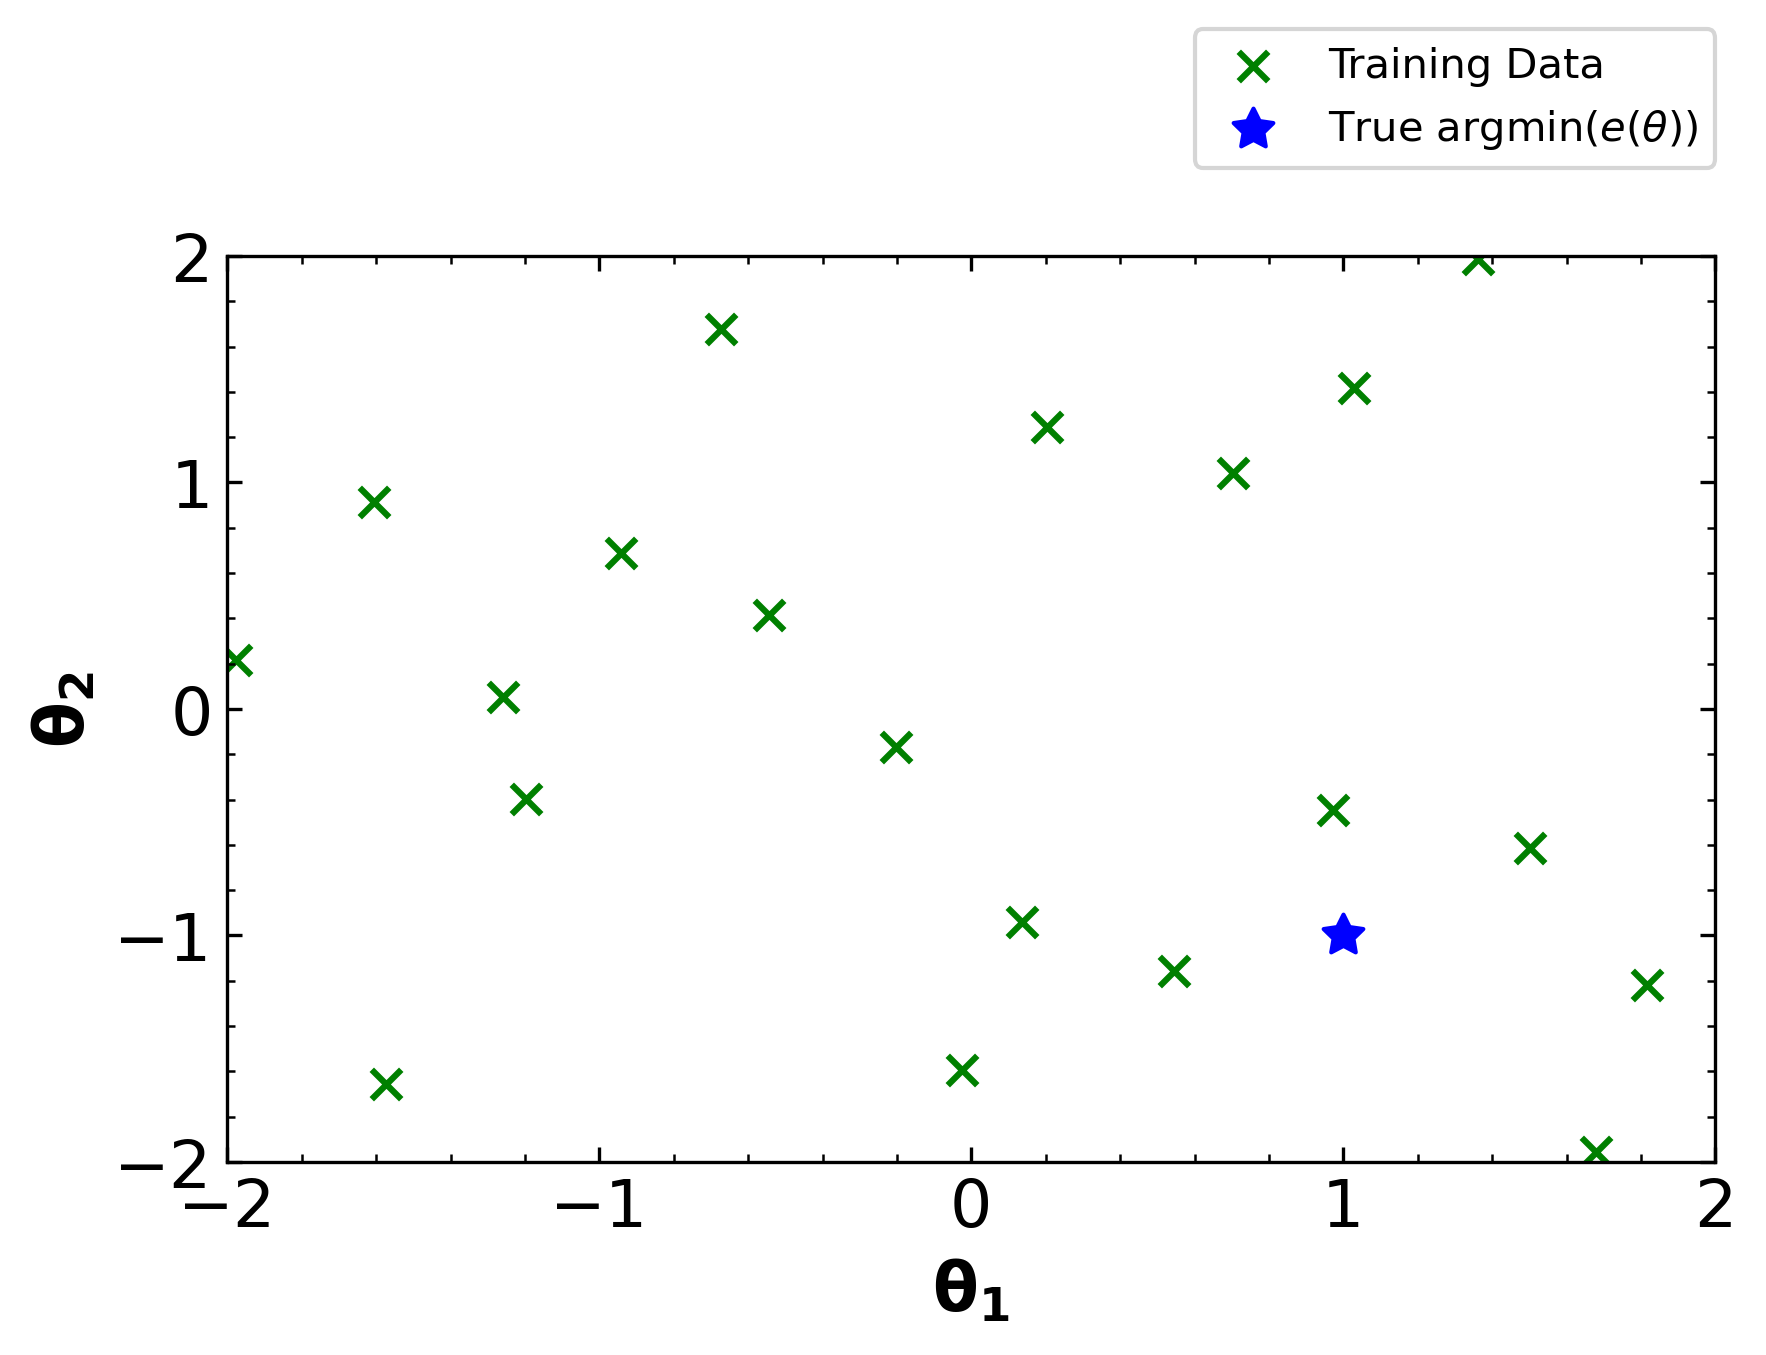

[[-2. -2.]]
[[-1.78947368 -2.        ]]
[[-1.57894737 -2.        ]]
[[-1.36842105 -2.        ]]
[[-1.15789474 -2.        ]]
[[-0.94736842 -2.        ]]
[[-0.73684211 -2.        ]]
[[-0.52631579 -2.        ]]
[[-0.31578947 -2.        ]]
[[-0.10526316 -2.        ]]
[[ 0.10526316 -2.        ]]
[[ 0.31578947 -2.        ]]
[[ 0.52631579 -2.        ]]
[[ 0.73684211 -2.        ]]
[[ 0.94736842 -2.        ]]
[[ 1.15789474 -2.        ]]
[[ 1.36842105 -2.        ]]
[[ 1.57894737 -2.        ]]
[[ 1.78947368 -2.        ]]
[[ 2. -2.]]
[[-2.         -1.78947368]]
[[-1.78947368 -1.78947368]]
[[-1.57894737 -1.78947368]]
[[-1.36842105 -1.78947368]]
[[-1.15789474 -1.78947368]]
[[-0.94736842 -1.78947368]]
[[-0.73684211 -1.78947368]]
[[-0.52631579 -1.78947368]]
[[-0.31578947 -1.78947368]]
[[-0.10526316 -1.78947368]]
[[ 0.10526316 -1.78947368]]
[[ 0.31578947 -1.78947368]]
[[ 0.52631579 -1.78947368]]
[[ 0.73684211 -1.78947368]]
[[ 0.94736842 -1.78947368]]
[[ 1.15789474 -1.78947368]]
[[ 1.36842105 -1.7894736

[[0.73684211 1.57894737]]
[[0.94736842 1.57894737]]
[[1.15789474 1.57894737]]
[[1.36842105 1.57894737]]
[[1.57894737 1.57894737]]
[[1.78947368 1.57894737]]
[[2.         1.57894737]]
[[-2.          1.78947368]]
[[-1.78947368  1.78947368]]
[[-1.57894737  1.78947368]]
[[-1.36842105  1.78947368]]
[[-1.15789474  1.78947368]]
[[-0.94736842  1.78947368]]
[[-0.73684211  1.78947368]]
[[-0.52631579  1.78947368]]
[[-0.31578947  1.78947368]]
[[-0.10526316  1.78947368]]
[[0.10526316 1.78947368]]
[[0.31578947 1.78947368]]
[[0.52631579 1.78947368]]
[[0.73684211 1.78947368]]
[[0.94736842 1.78947368]]
[[1.15789474 1.78947368]]
[[1.36842105 1.78947368]]
[[1.57894737 1.78947368]]
[[1.78947368 1.78947368]]
[[2.         1.78947368]]
[[-2.  2.]]
[[-1.78947368  2.        ]]
[[-1.57894737  2.        ]]
[[-1.36842105  2.        ]]
[[-1.15789474  2.        ]]
[[-0.94736842  2.        ]]
[[-0.73684211  2.        ]]
[[-0.52631579  2.        ]]
[[-0.31578947  2.        ]]
[[-0.10526316  2.        ]]
[[0.10526316 2

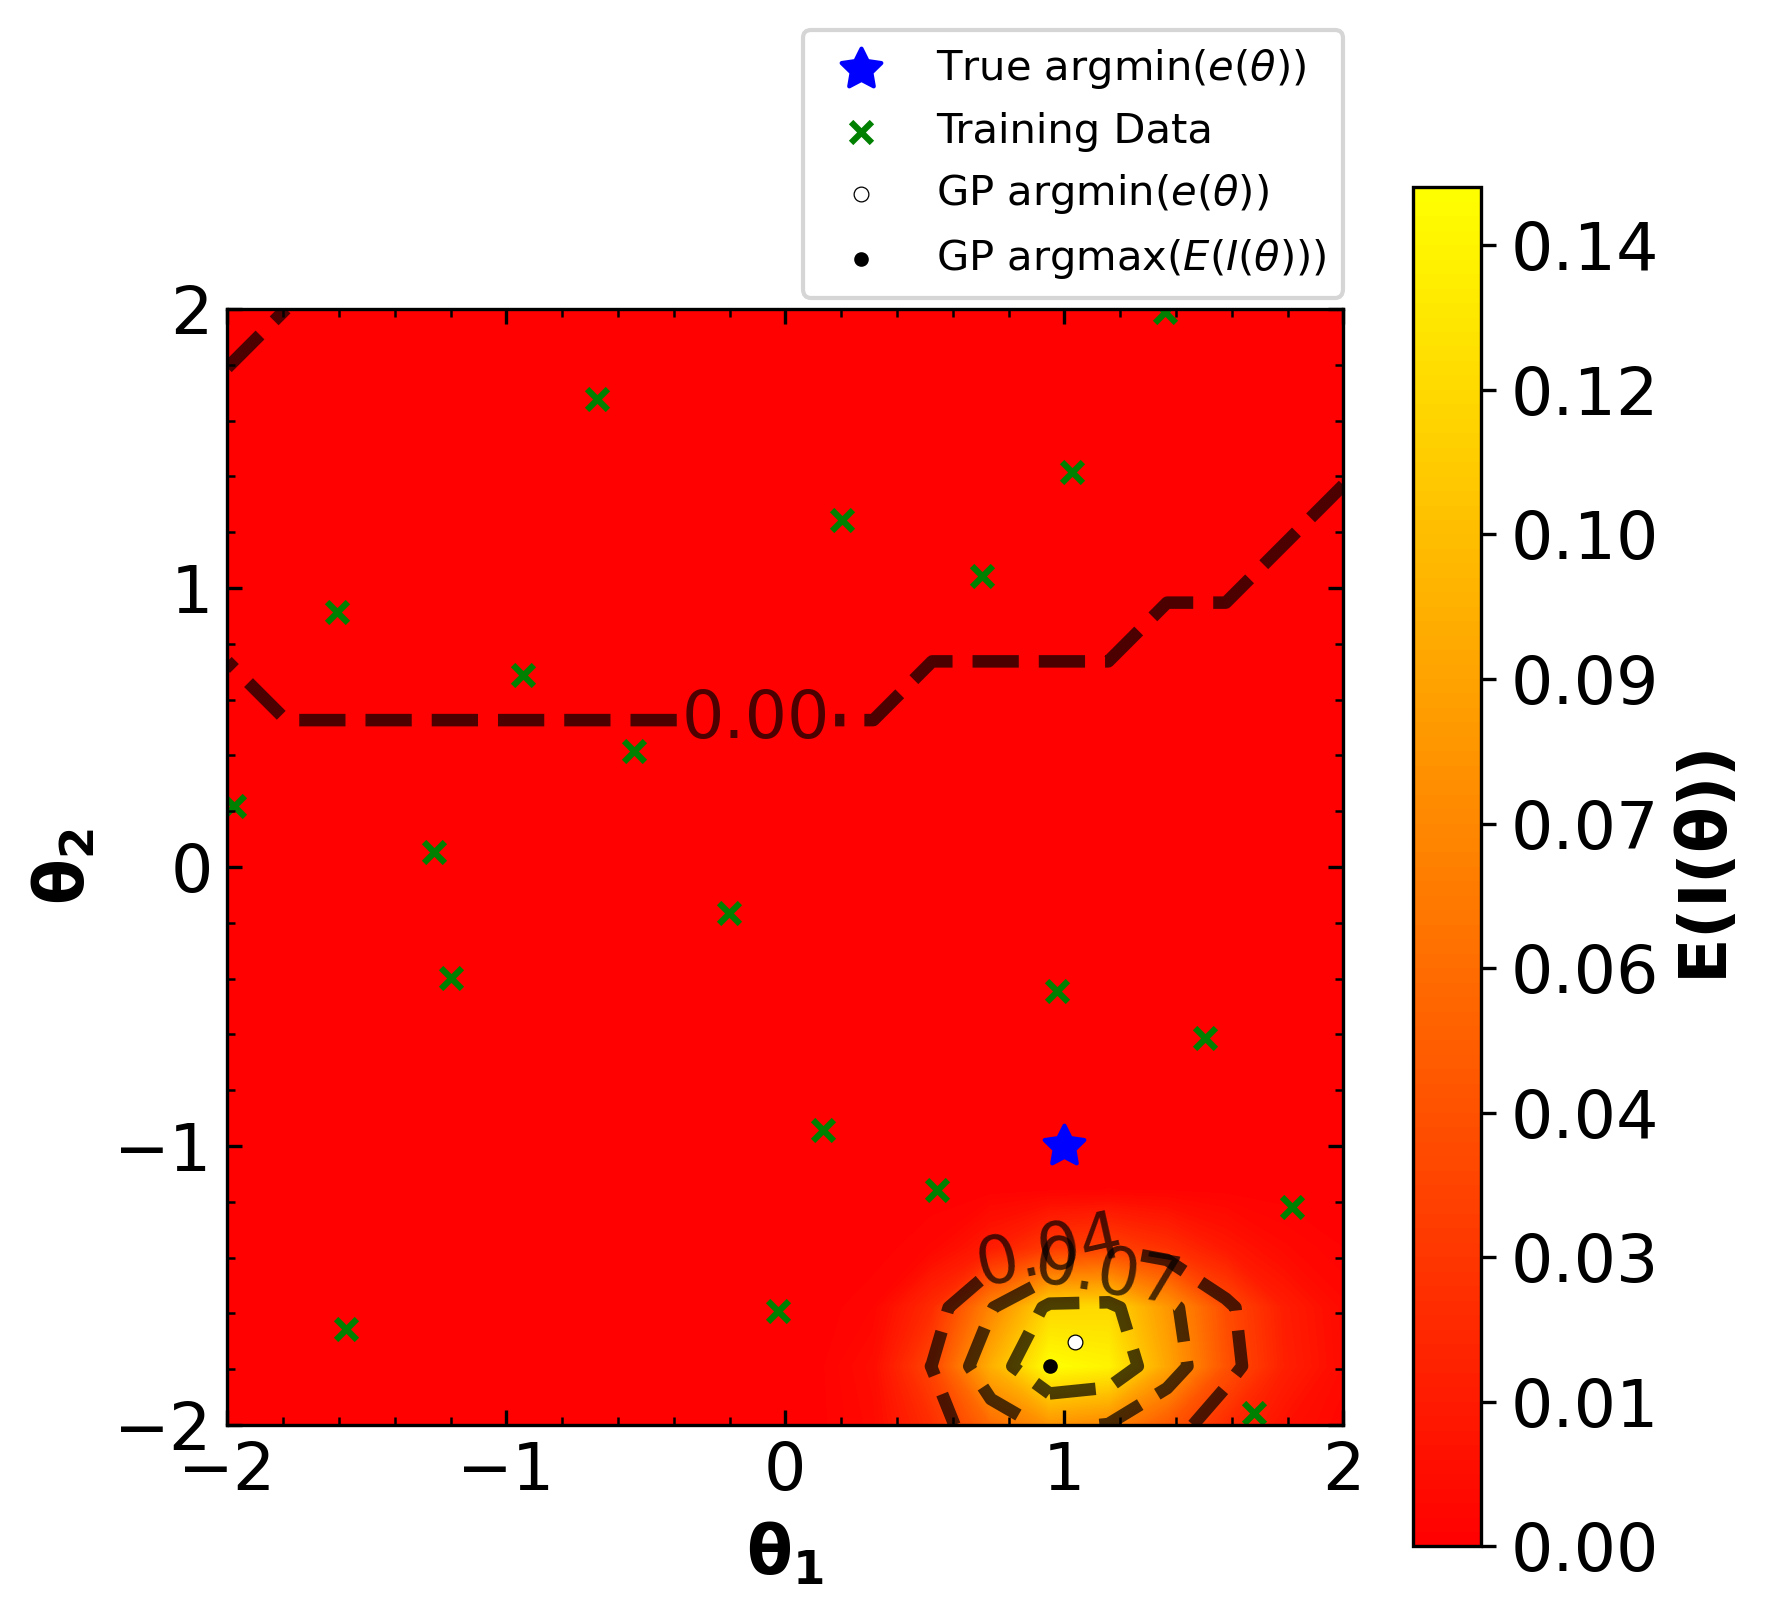

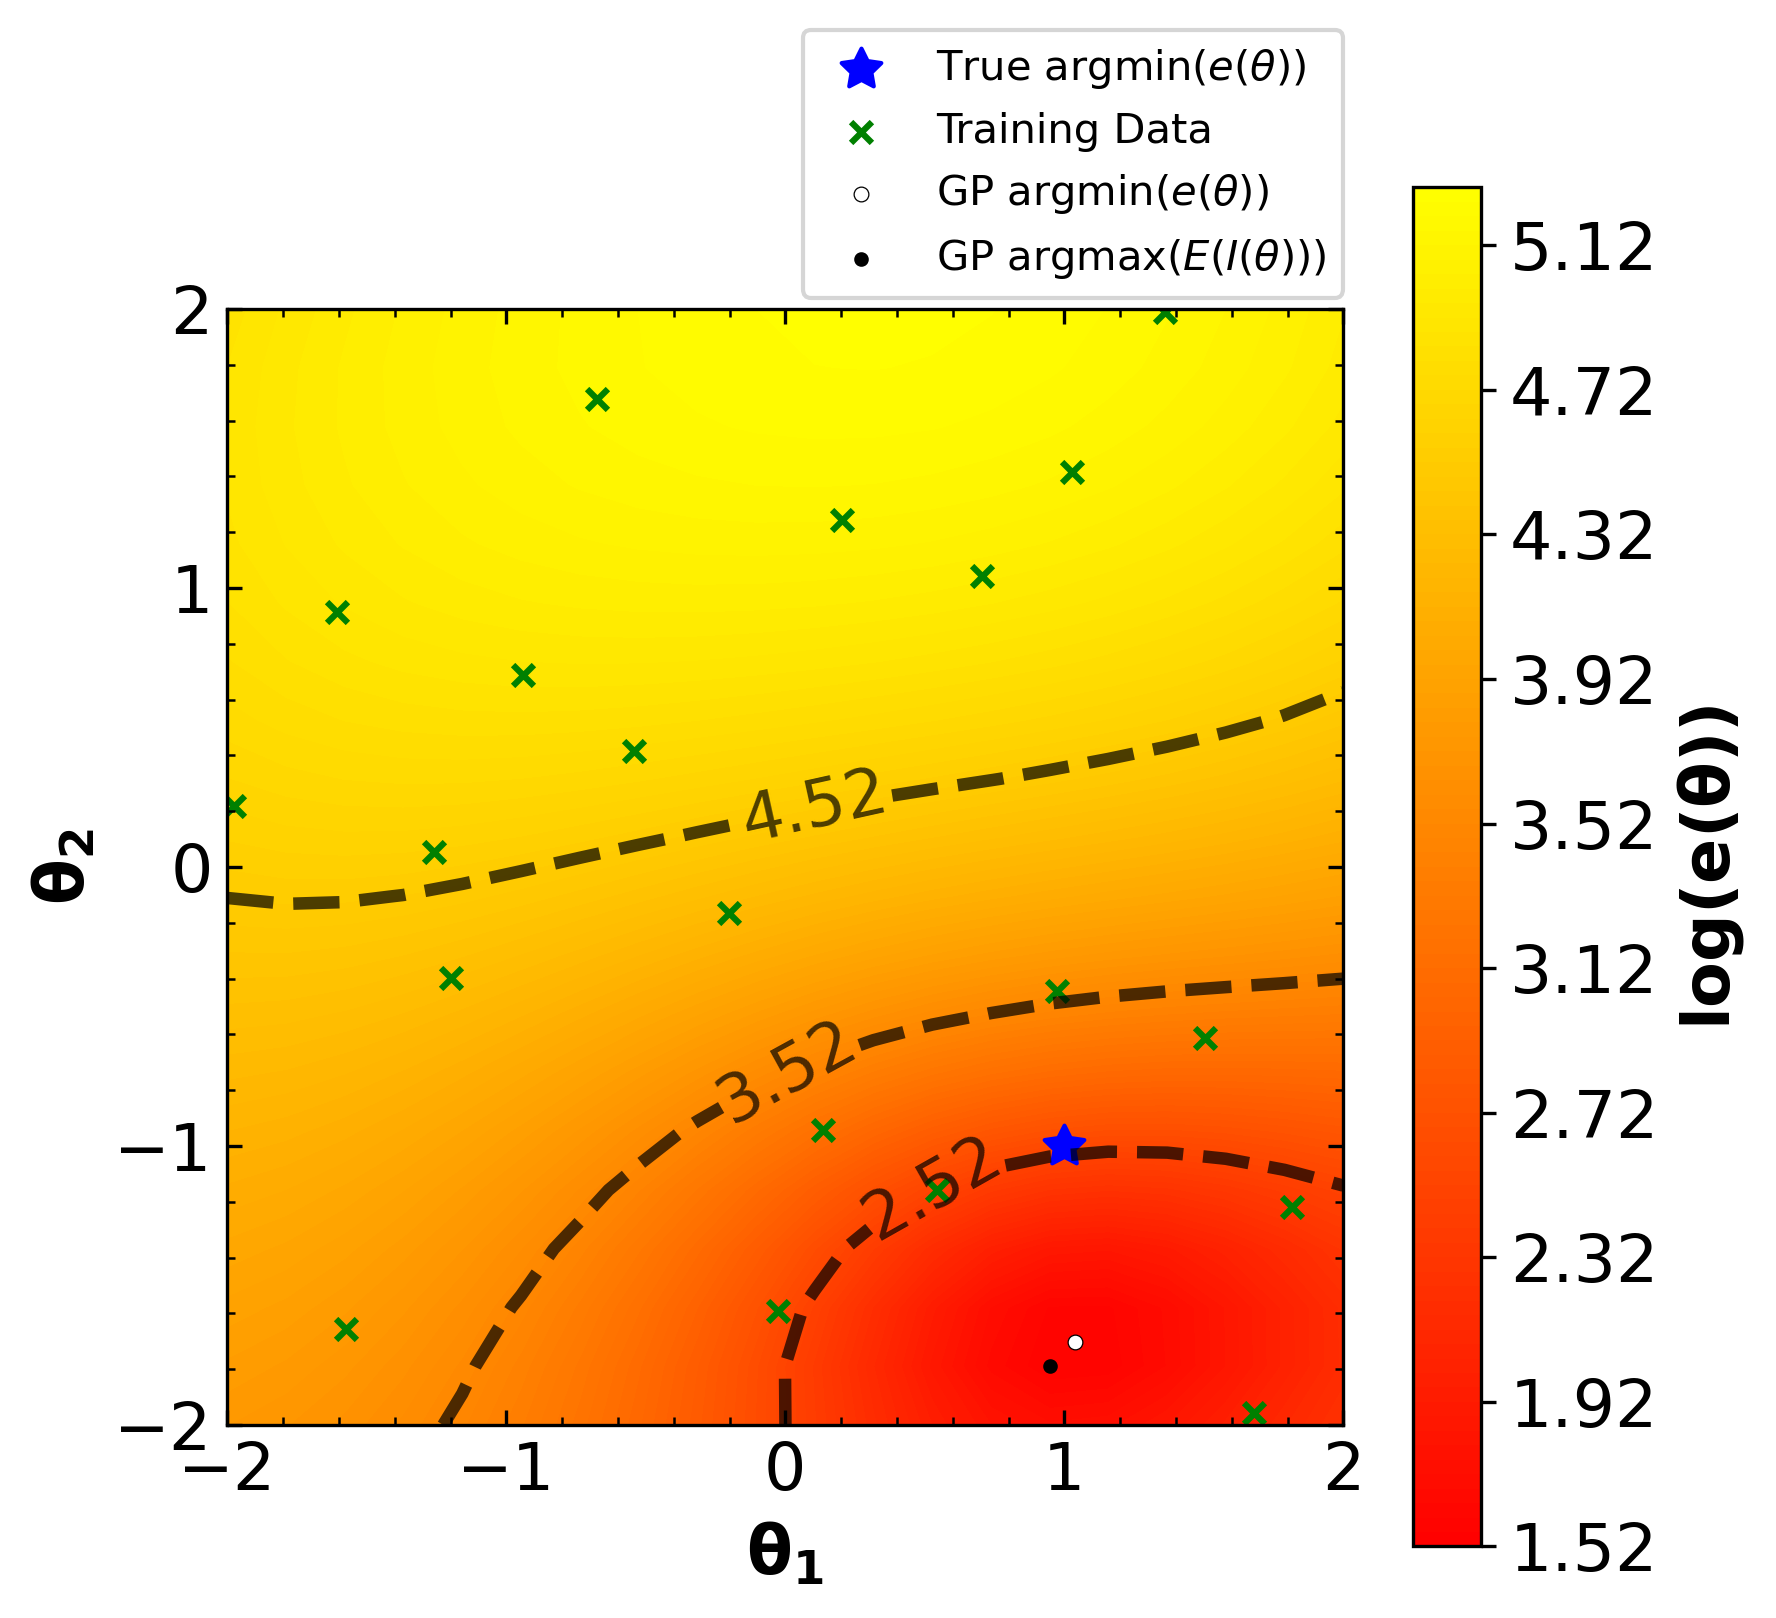

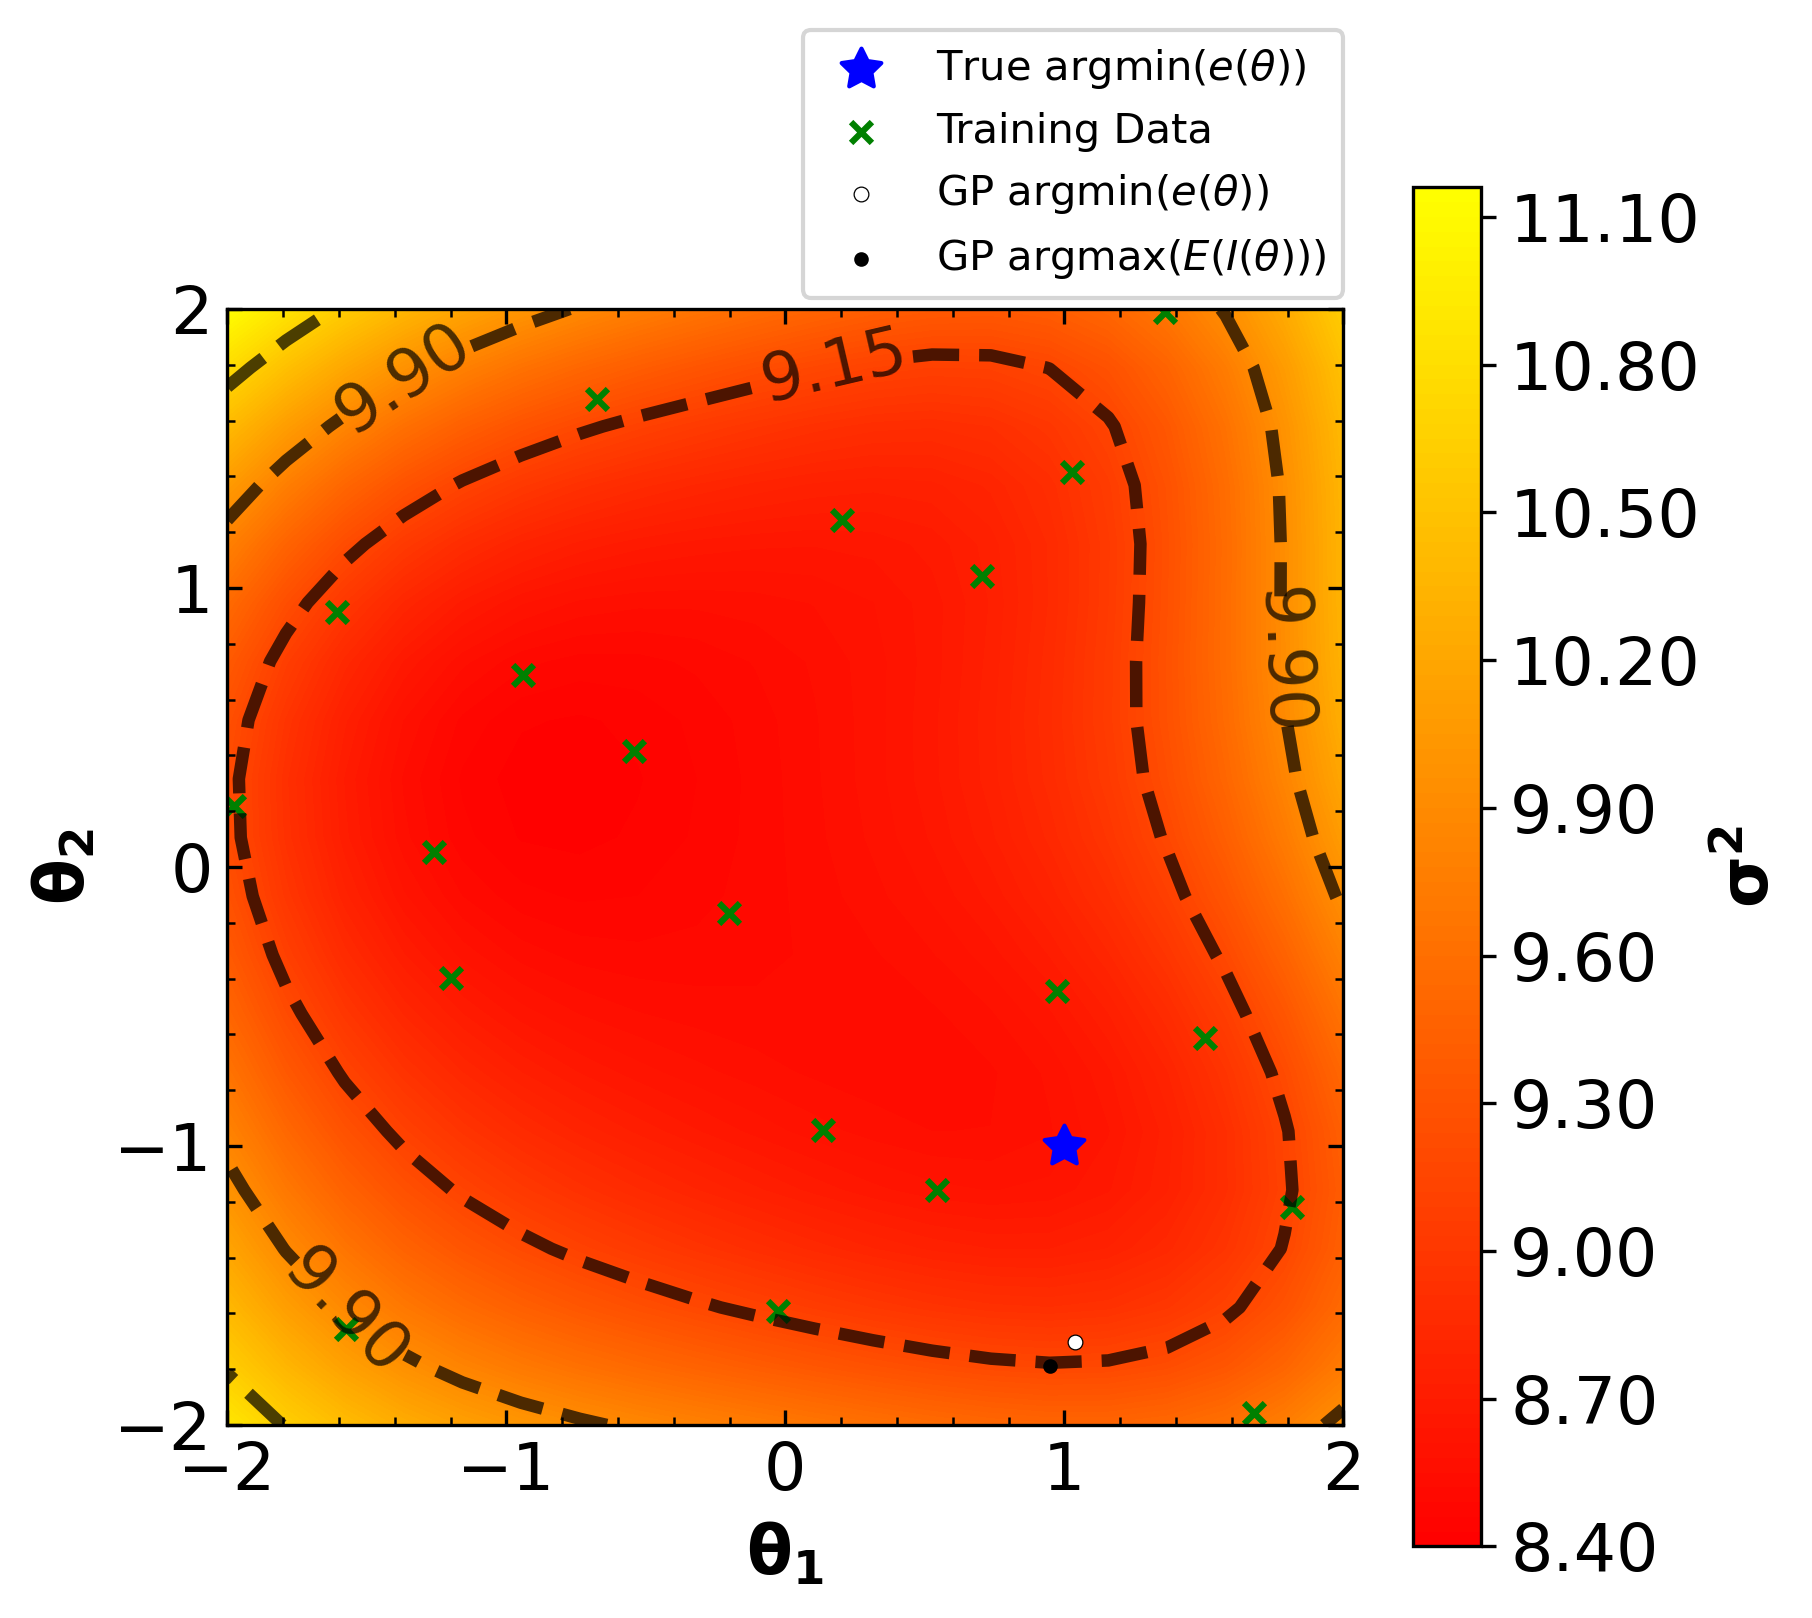

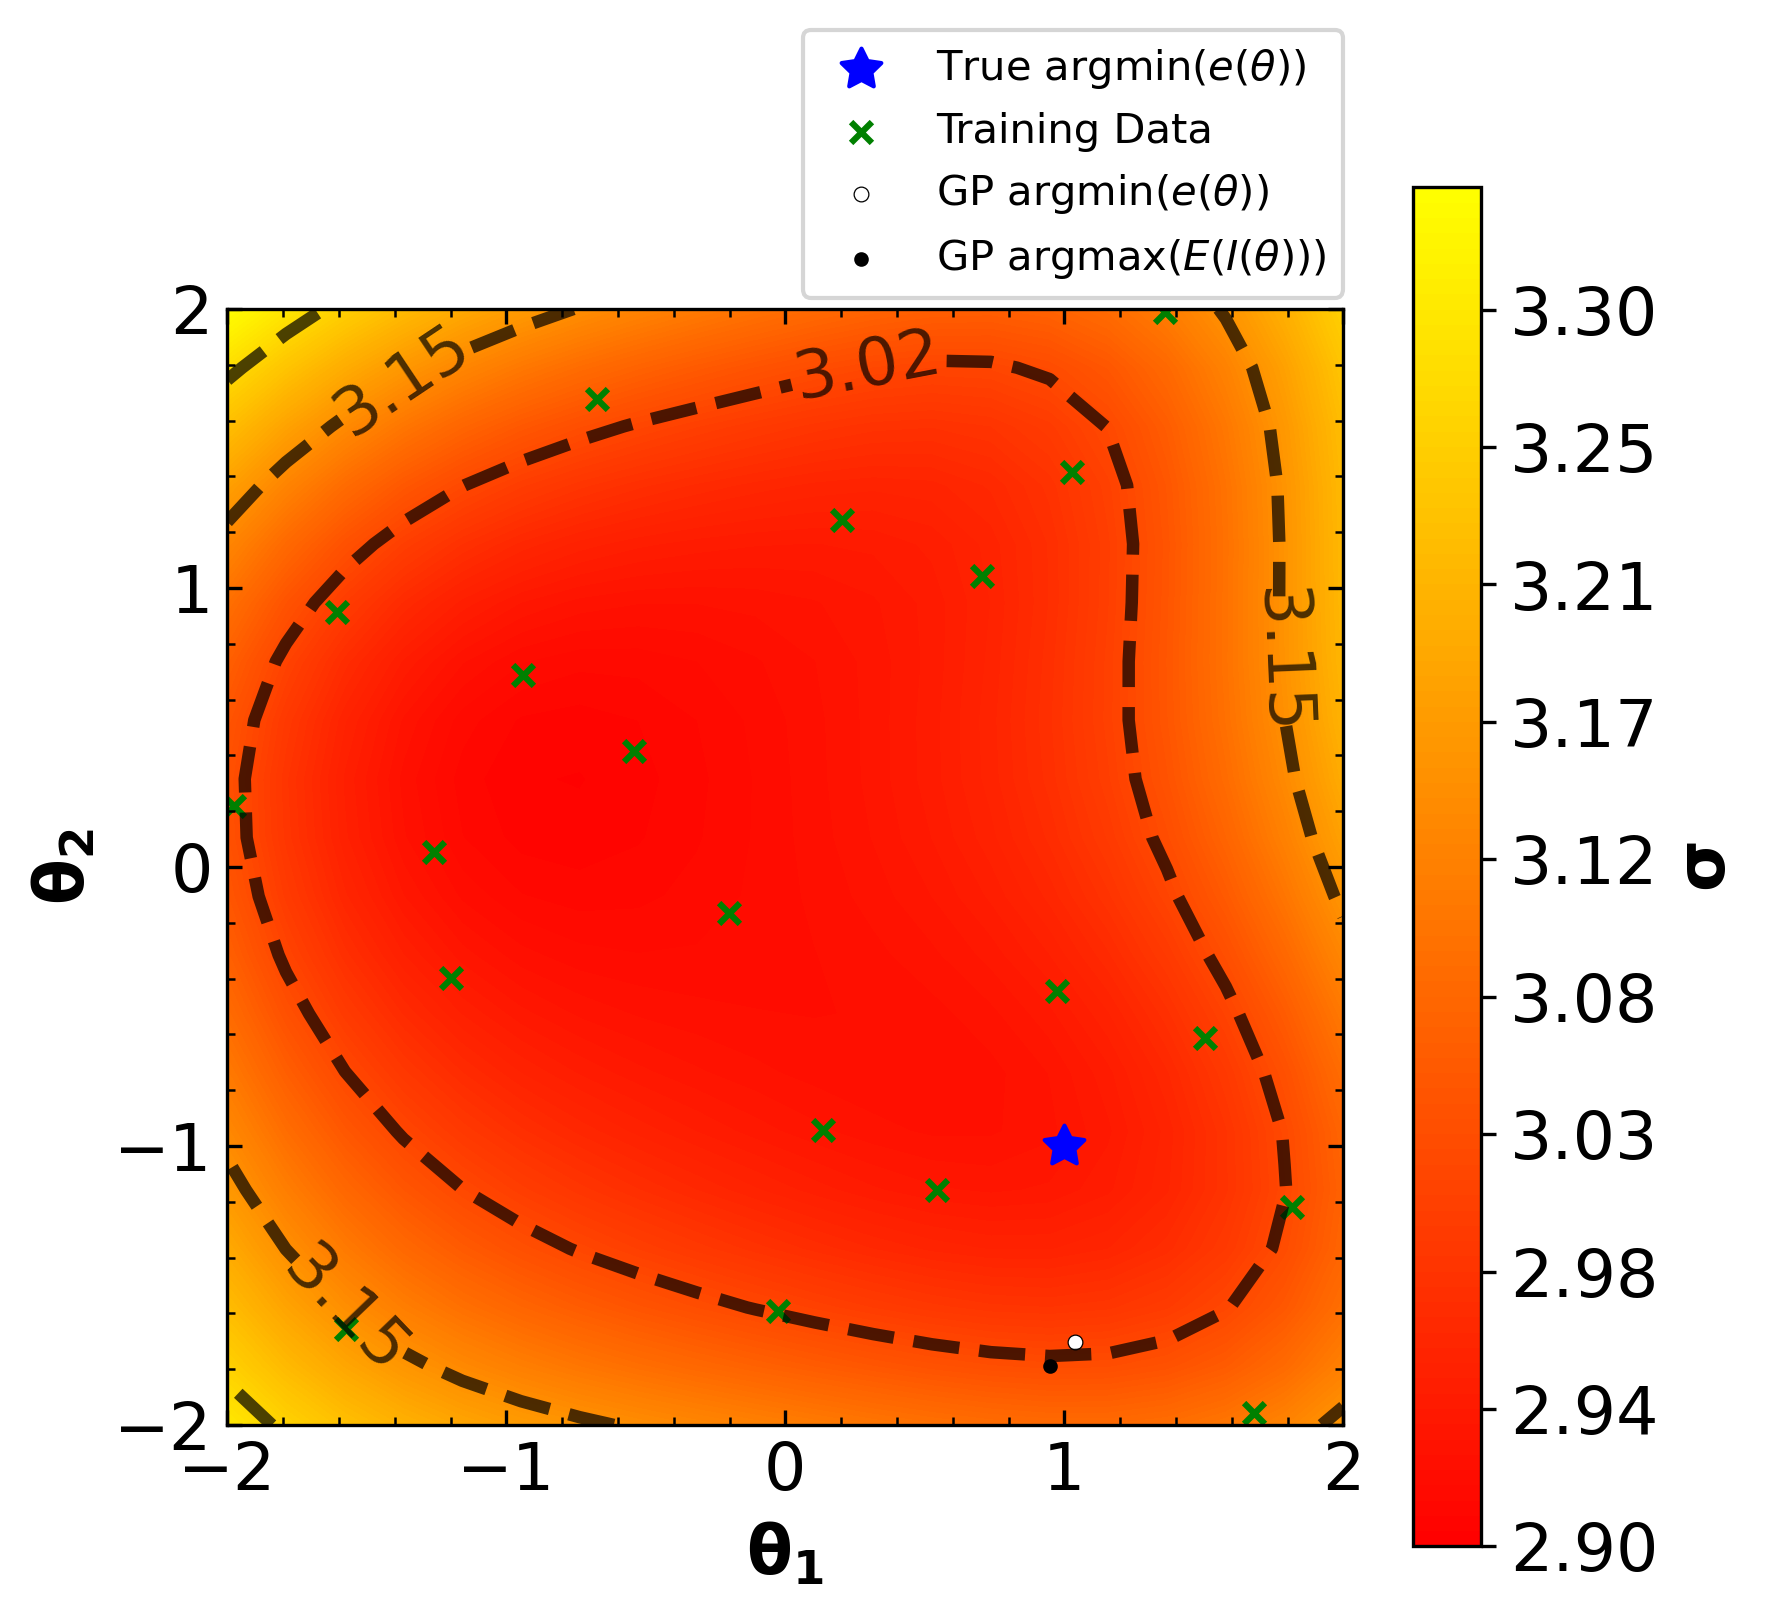

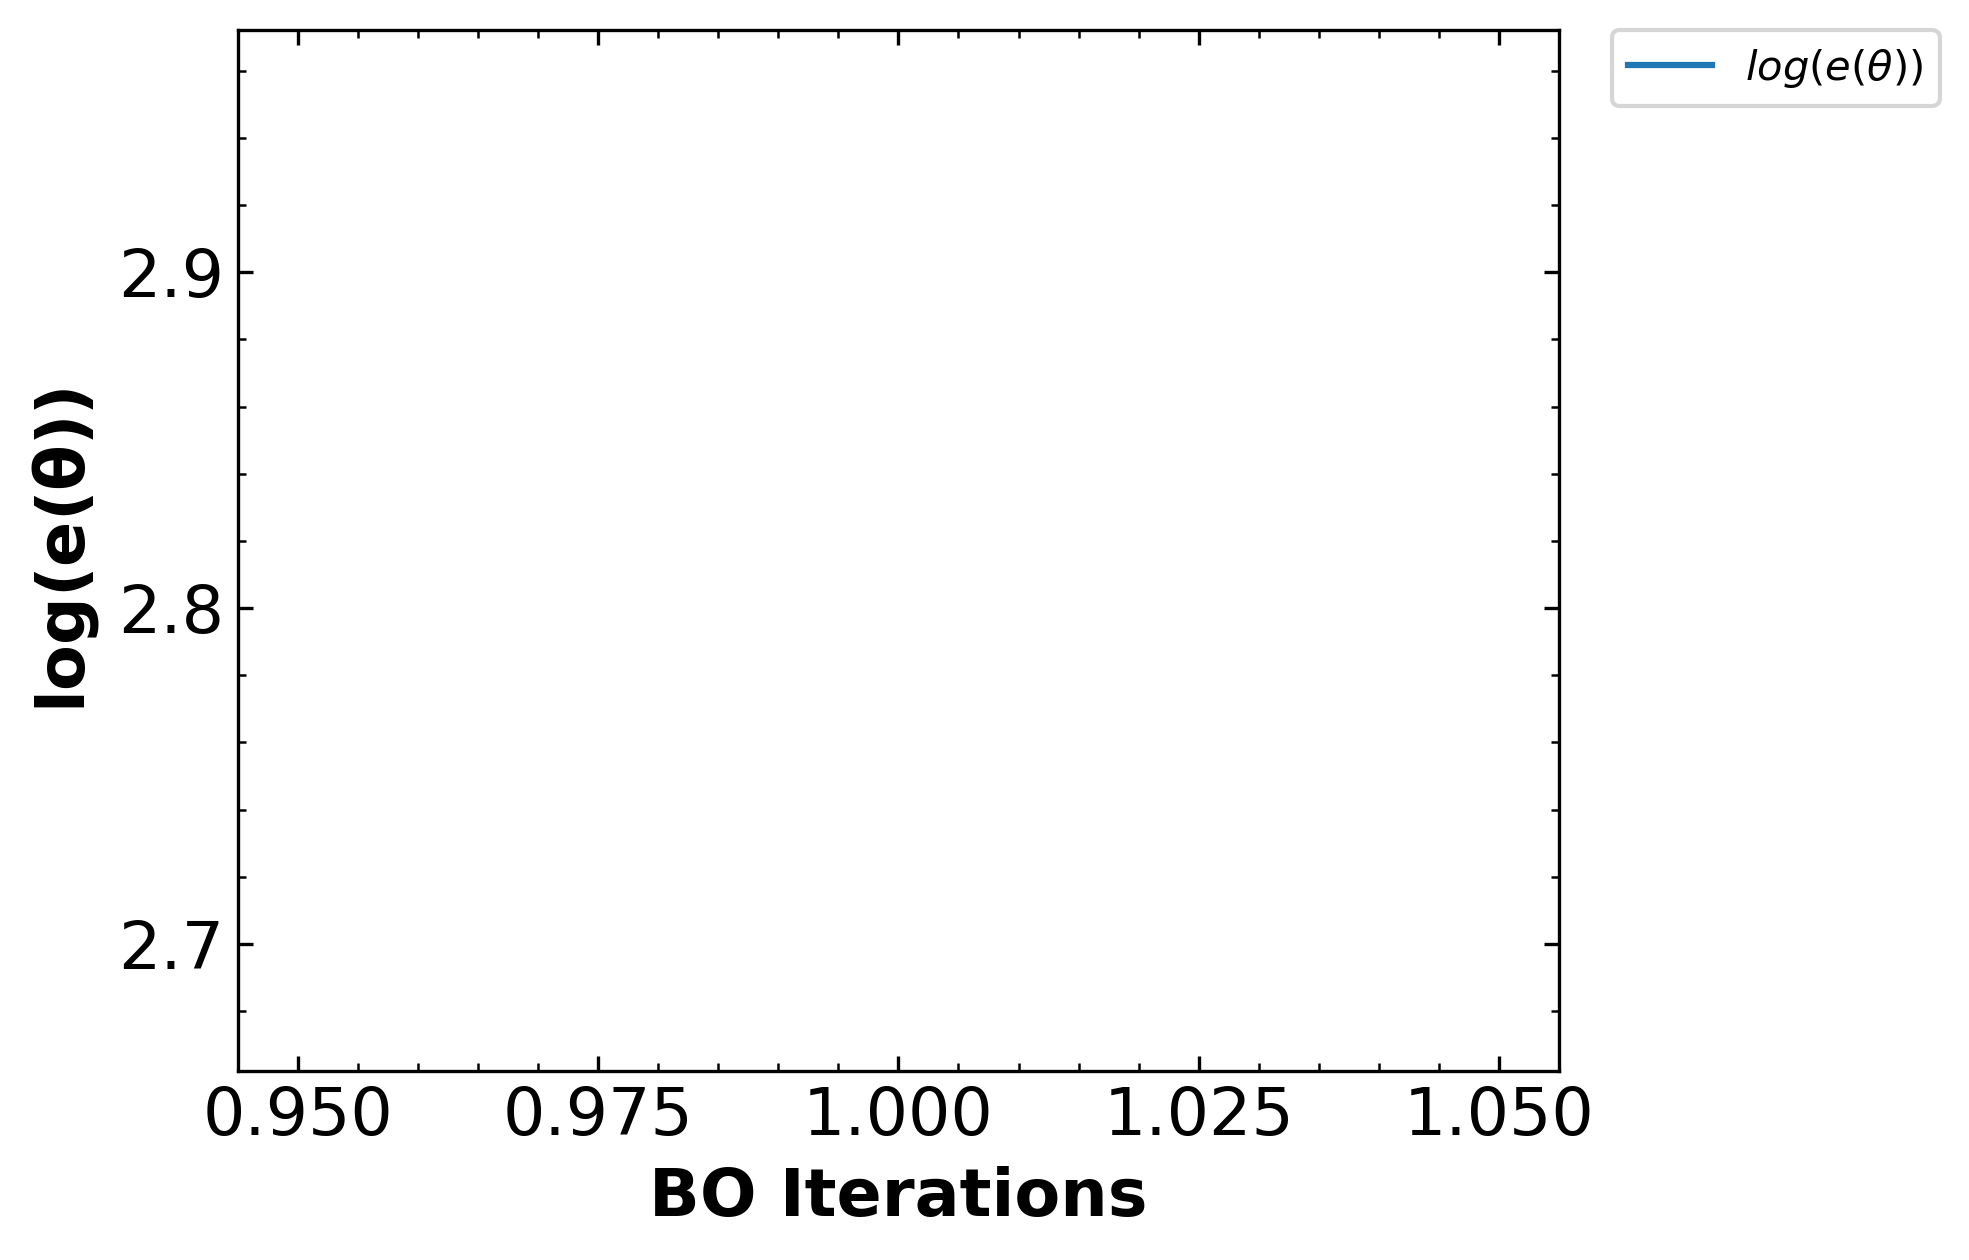

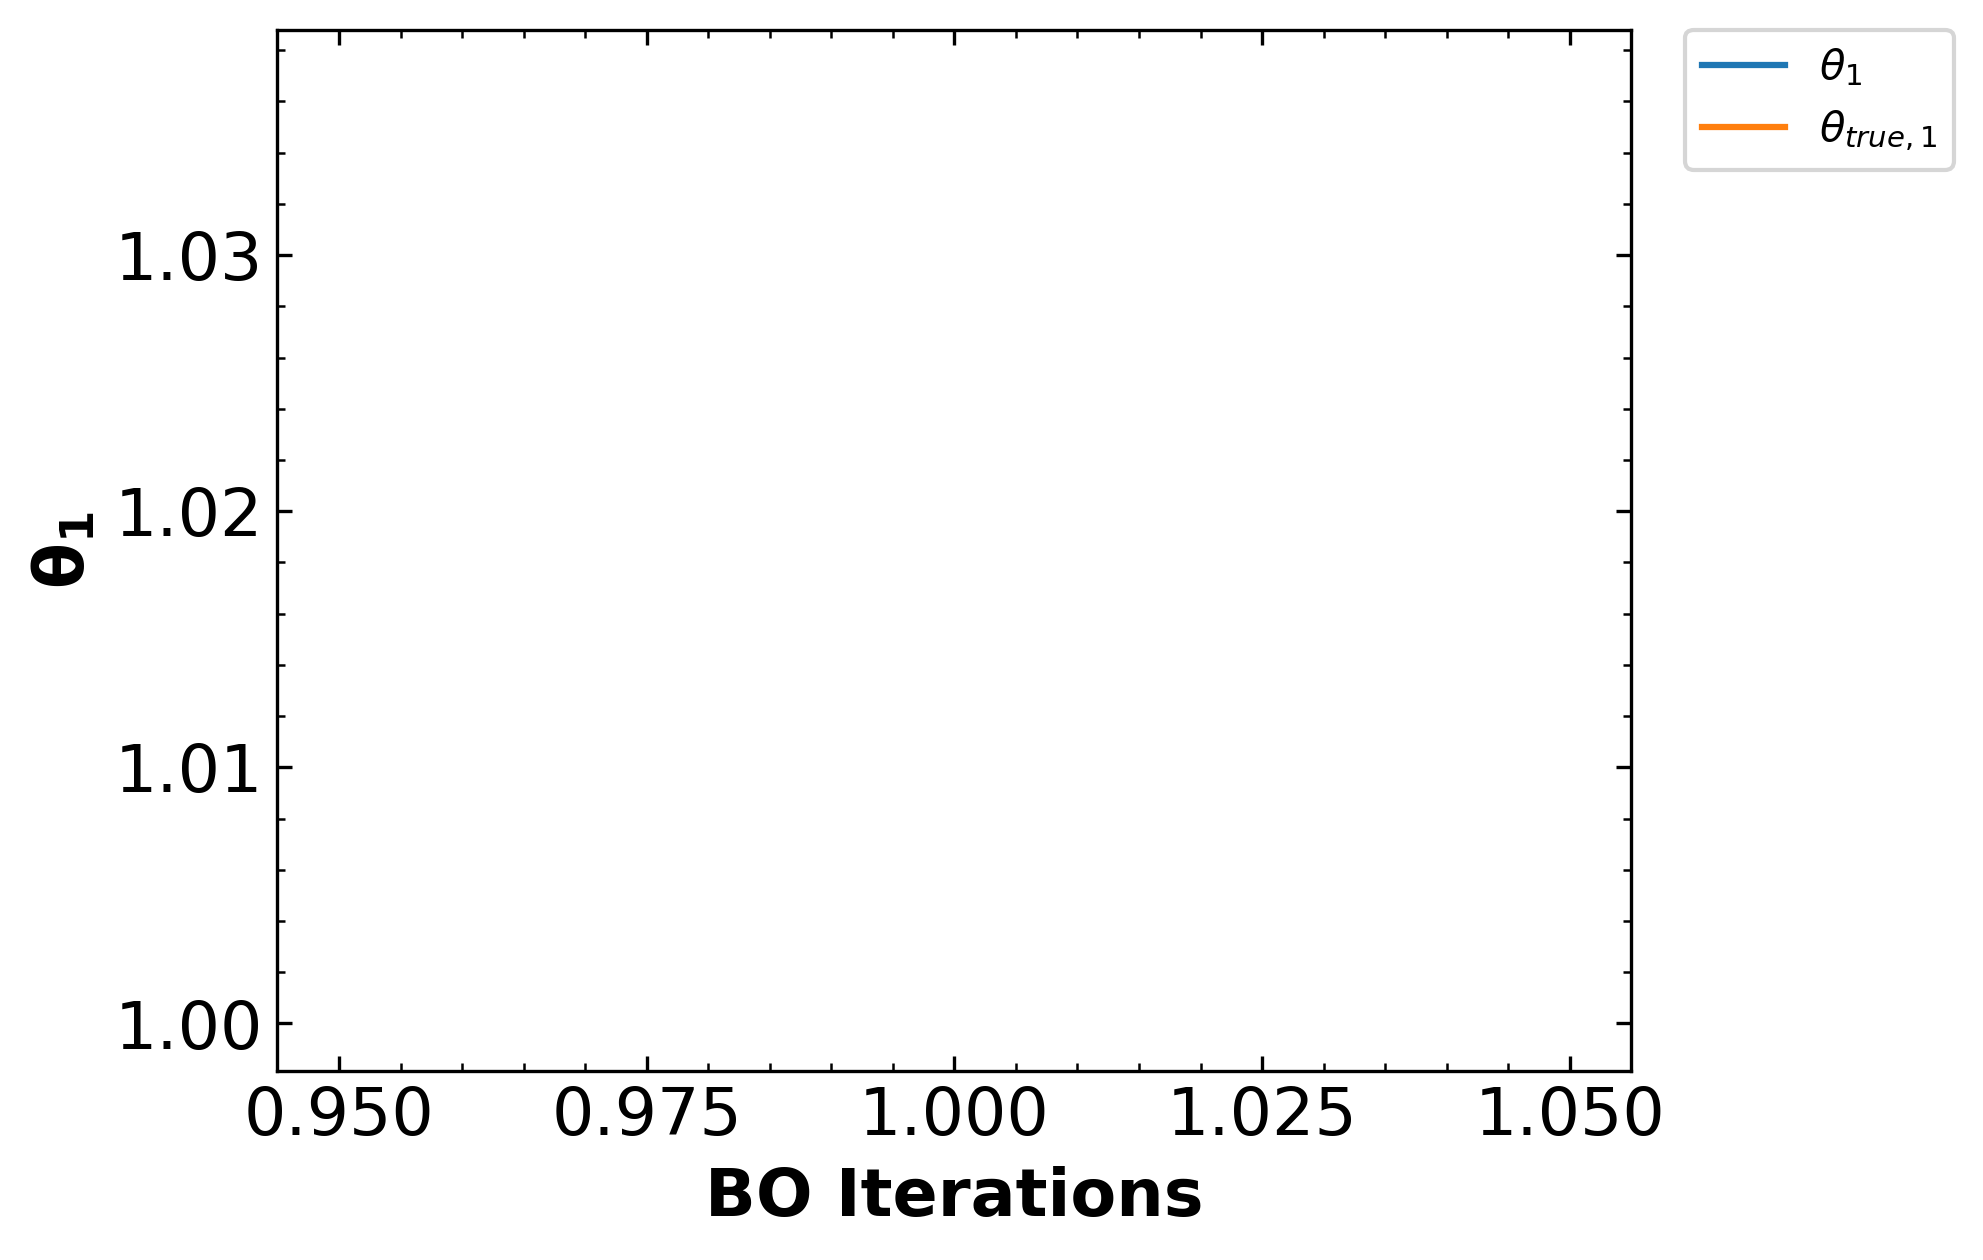

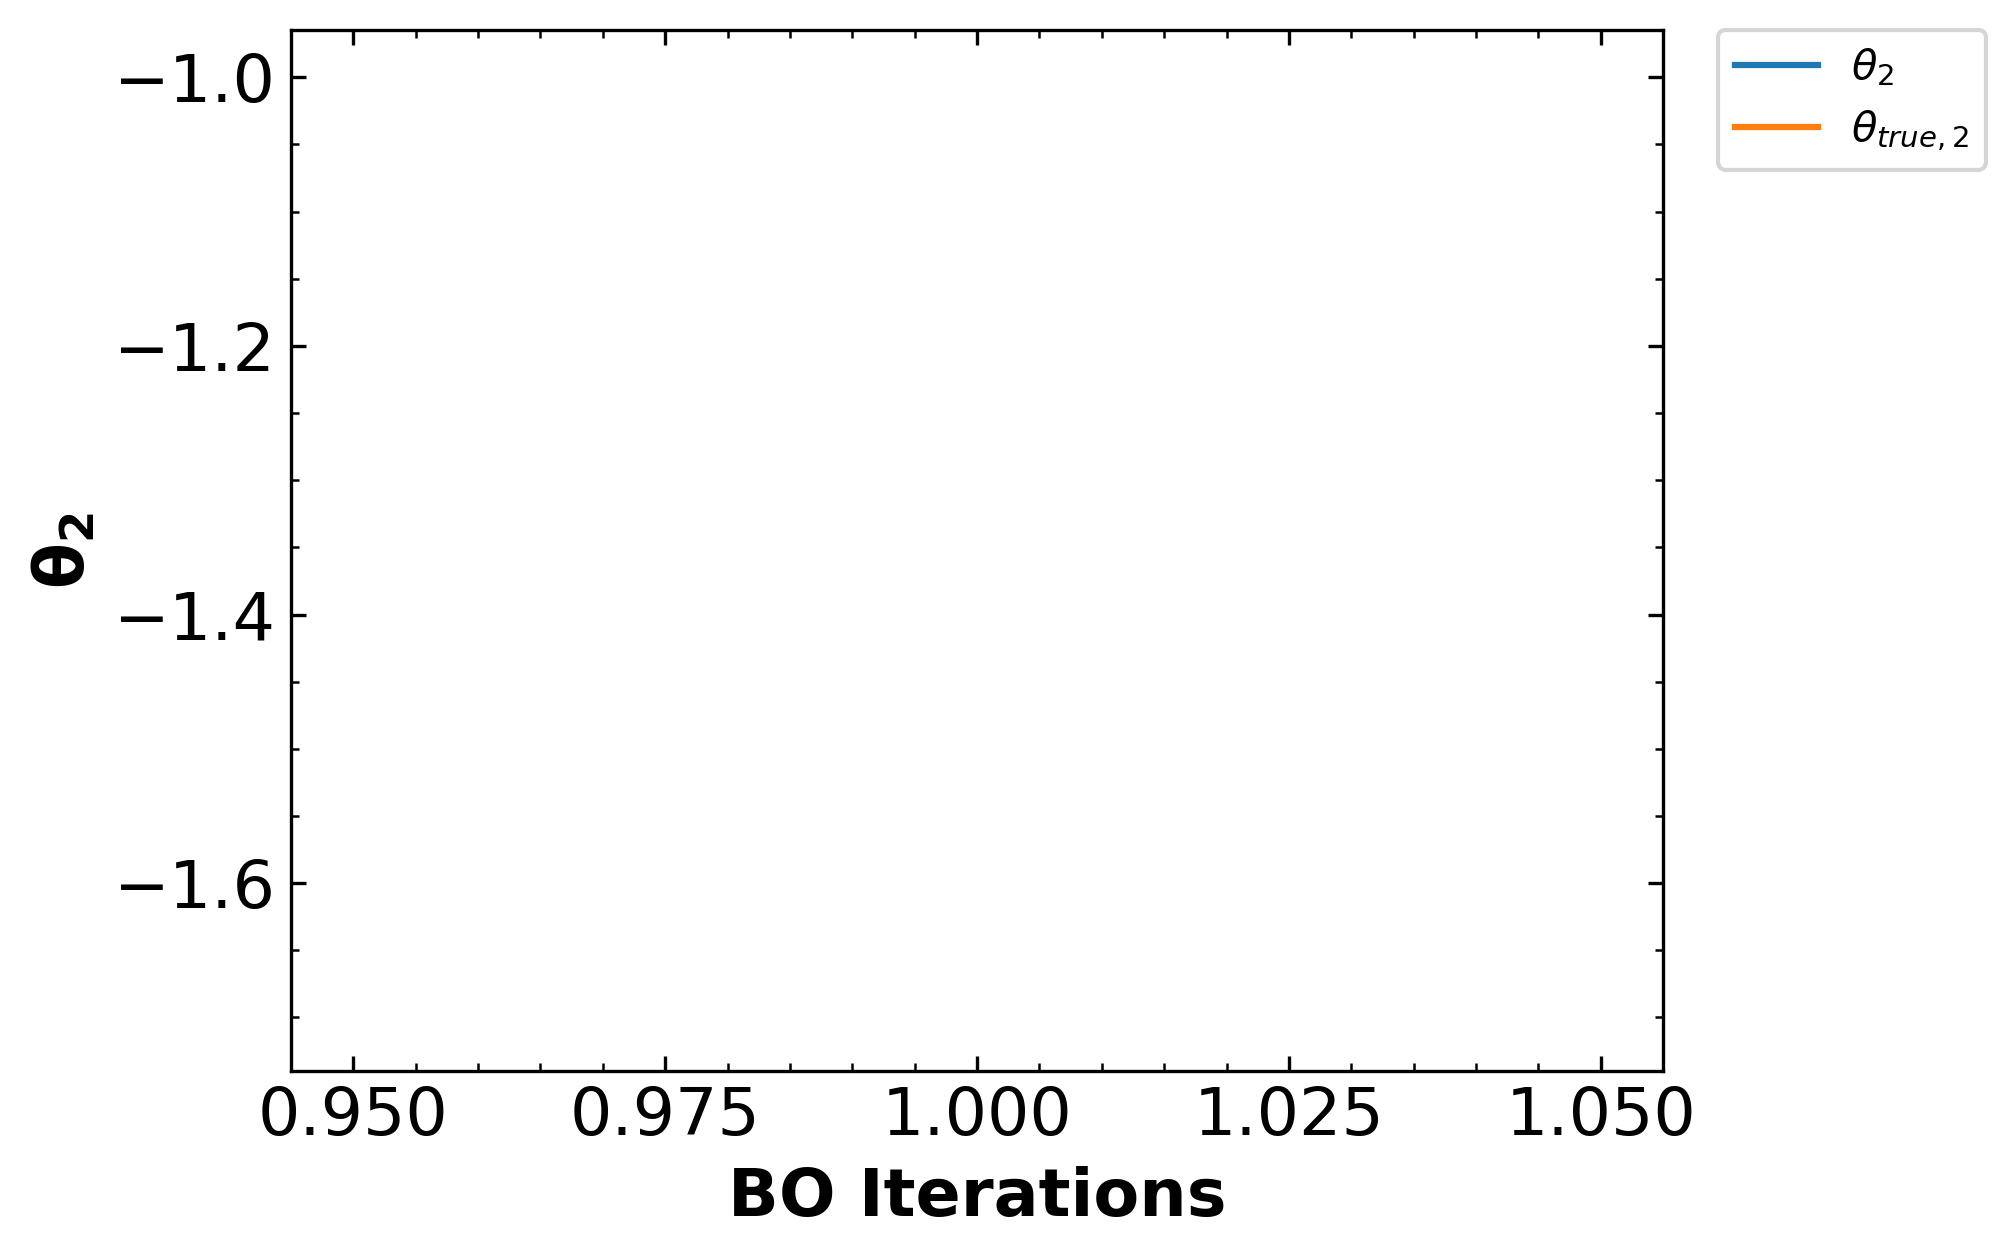

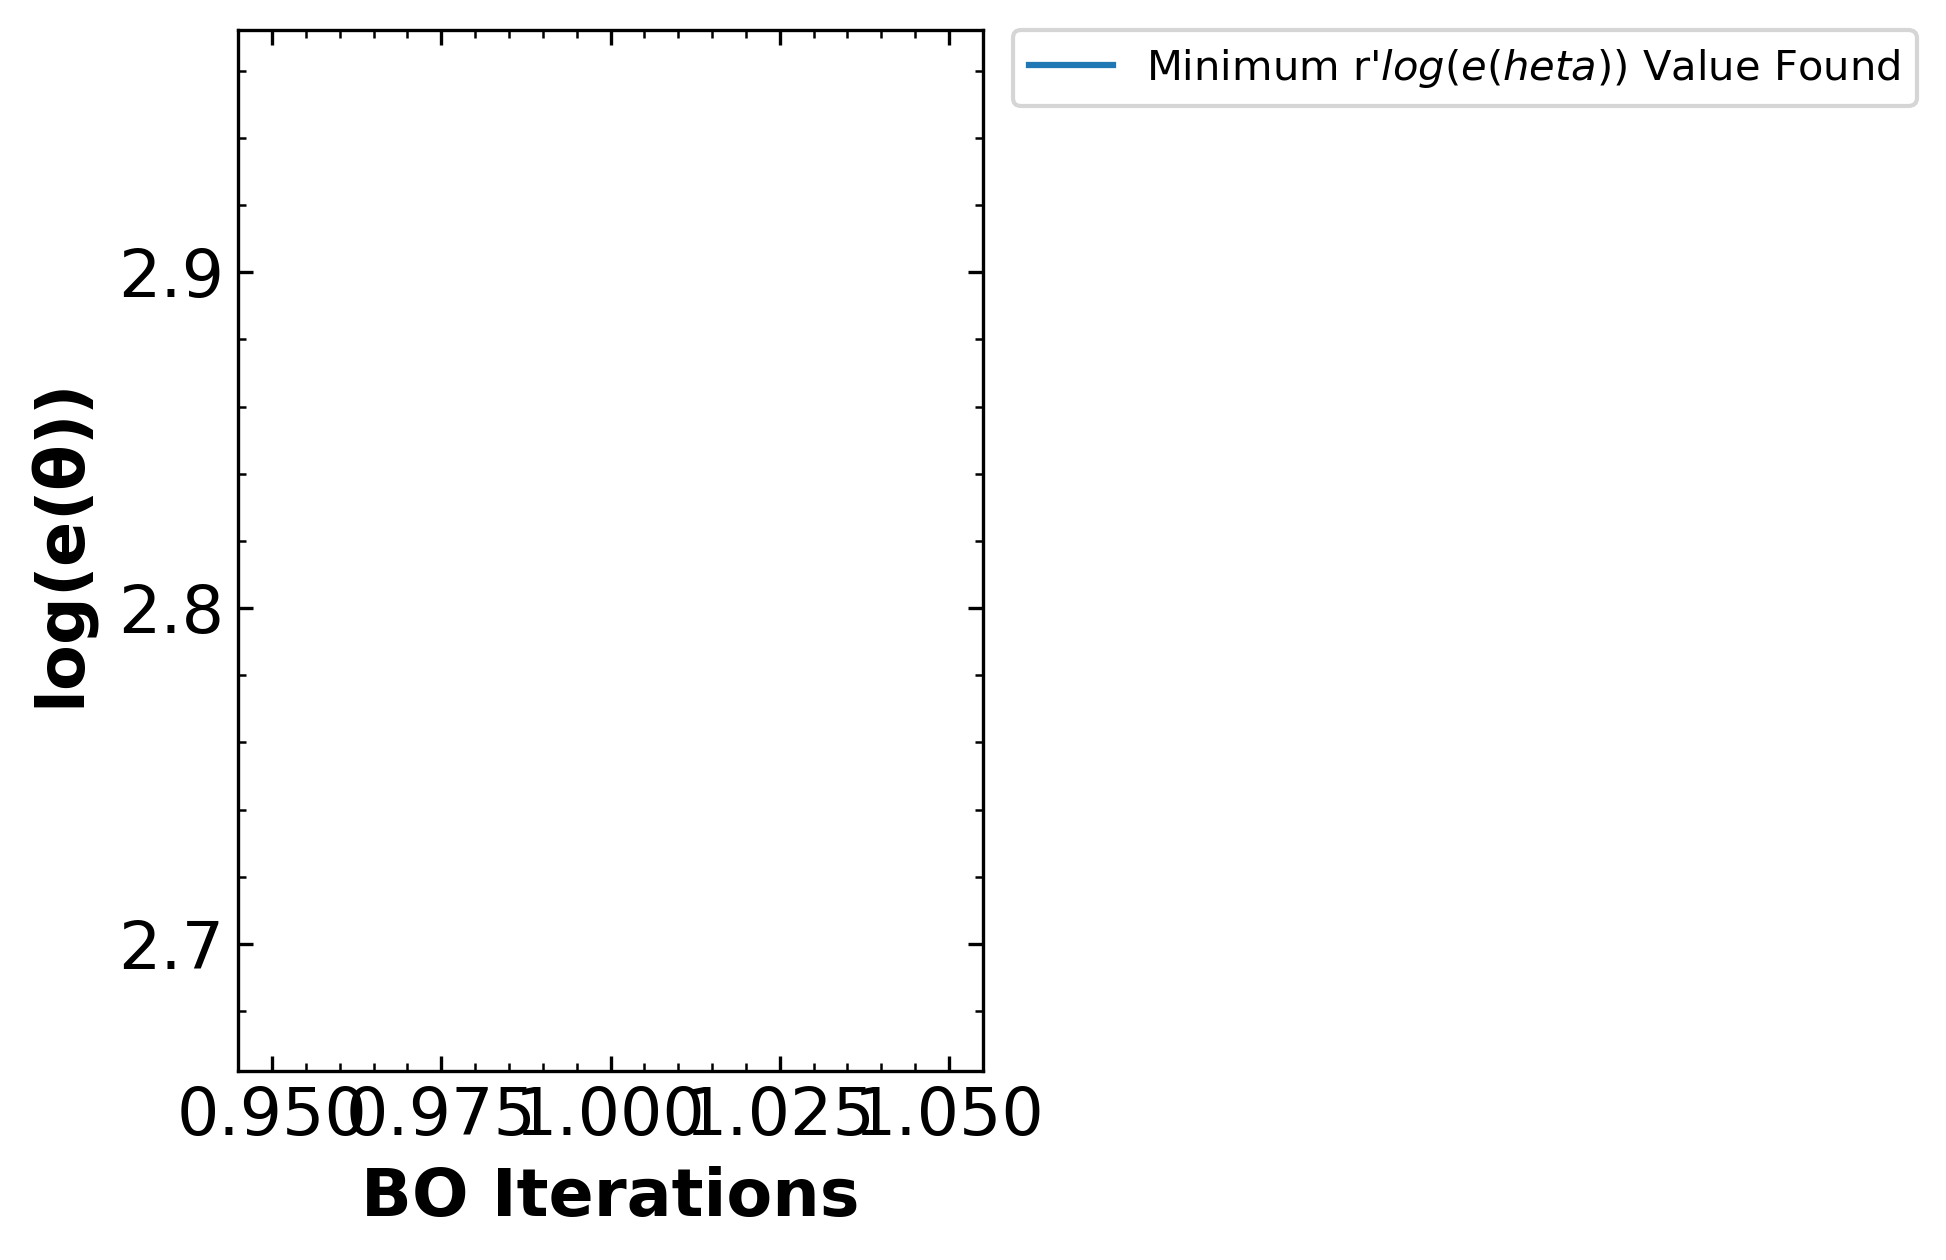

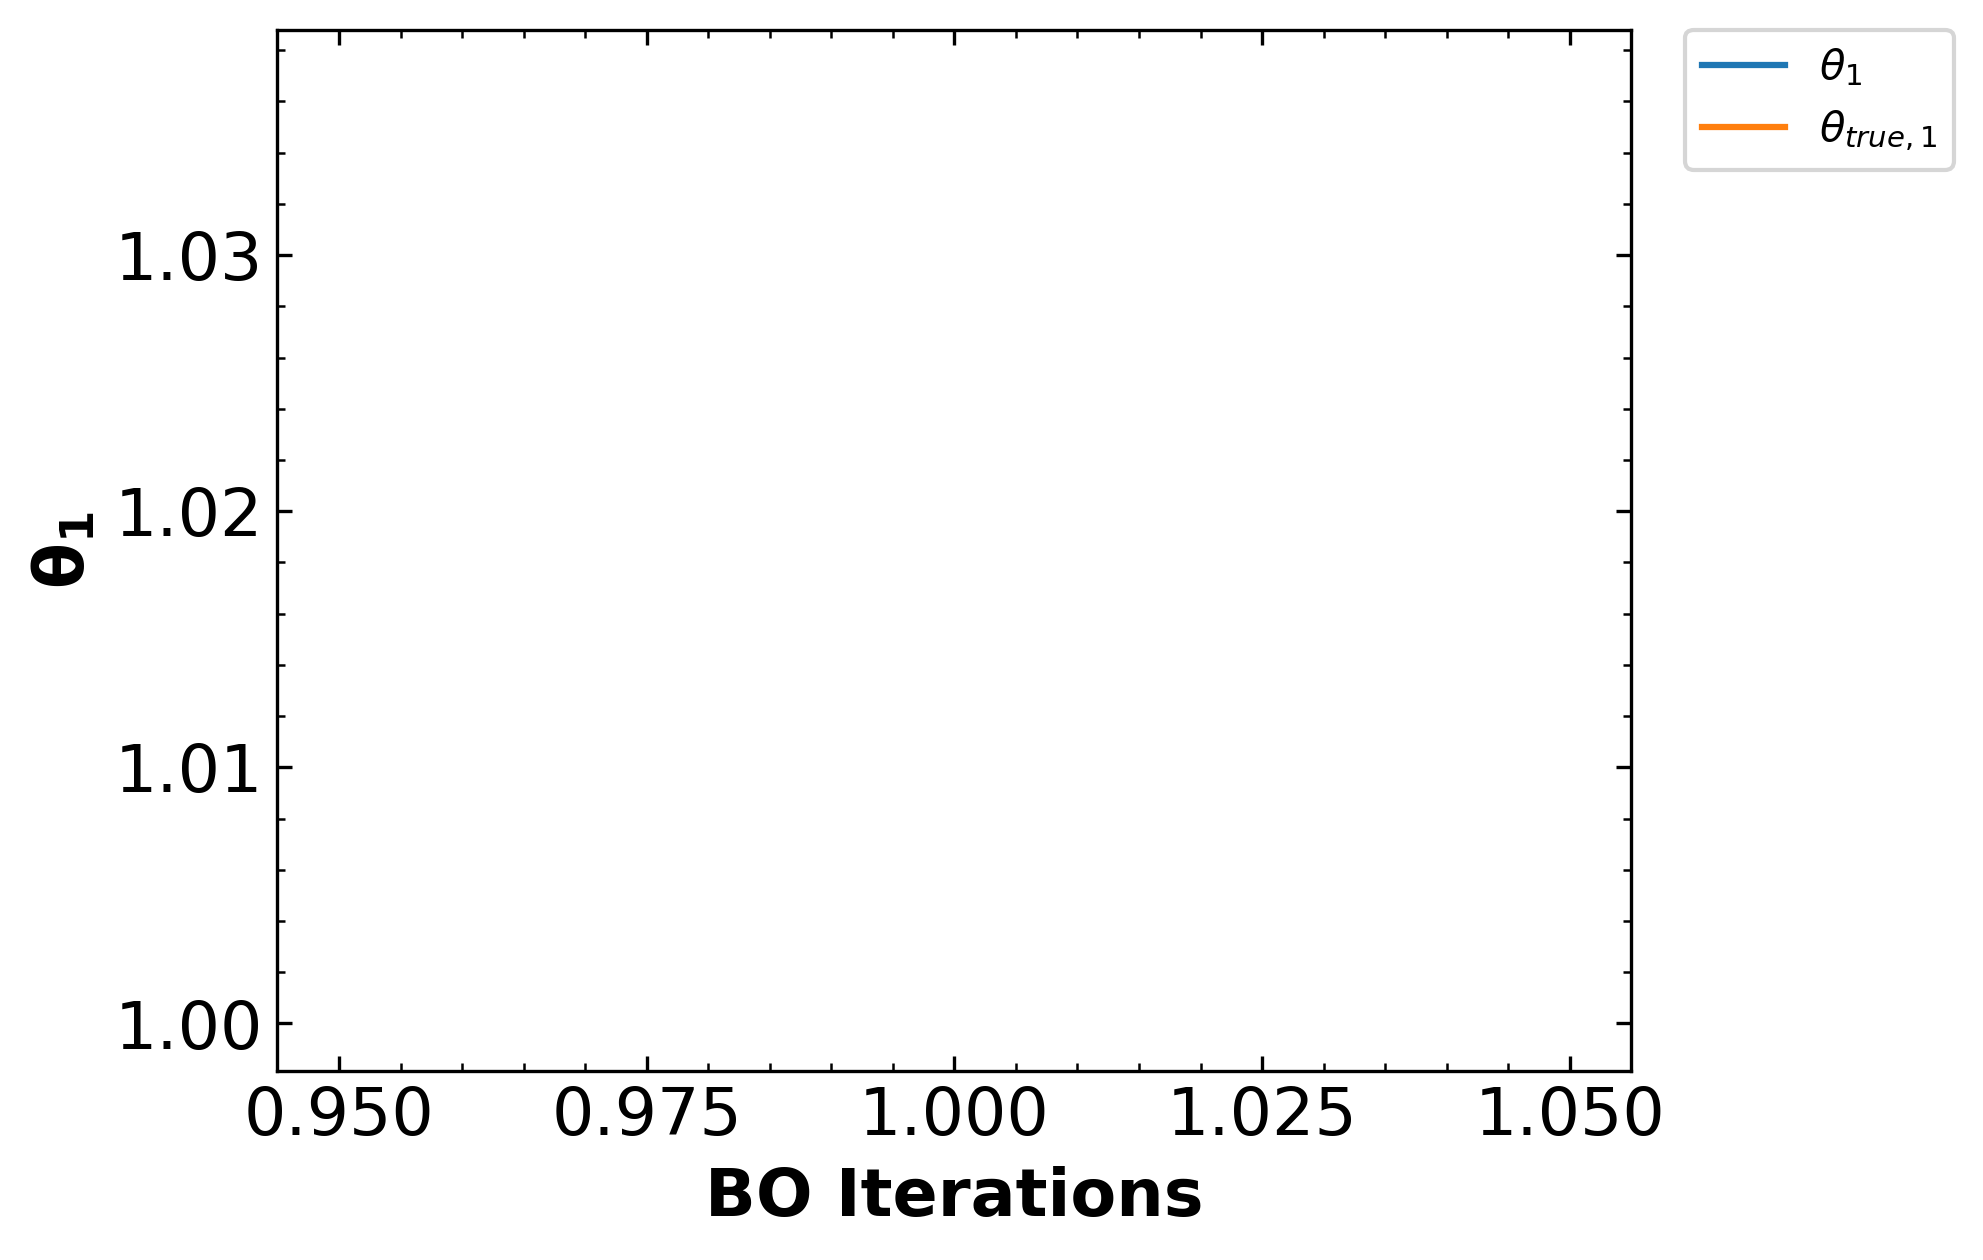

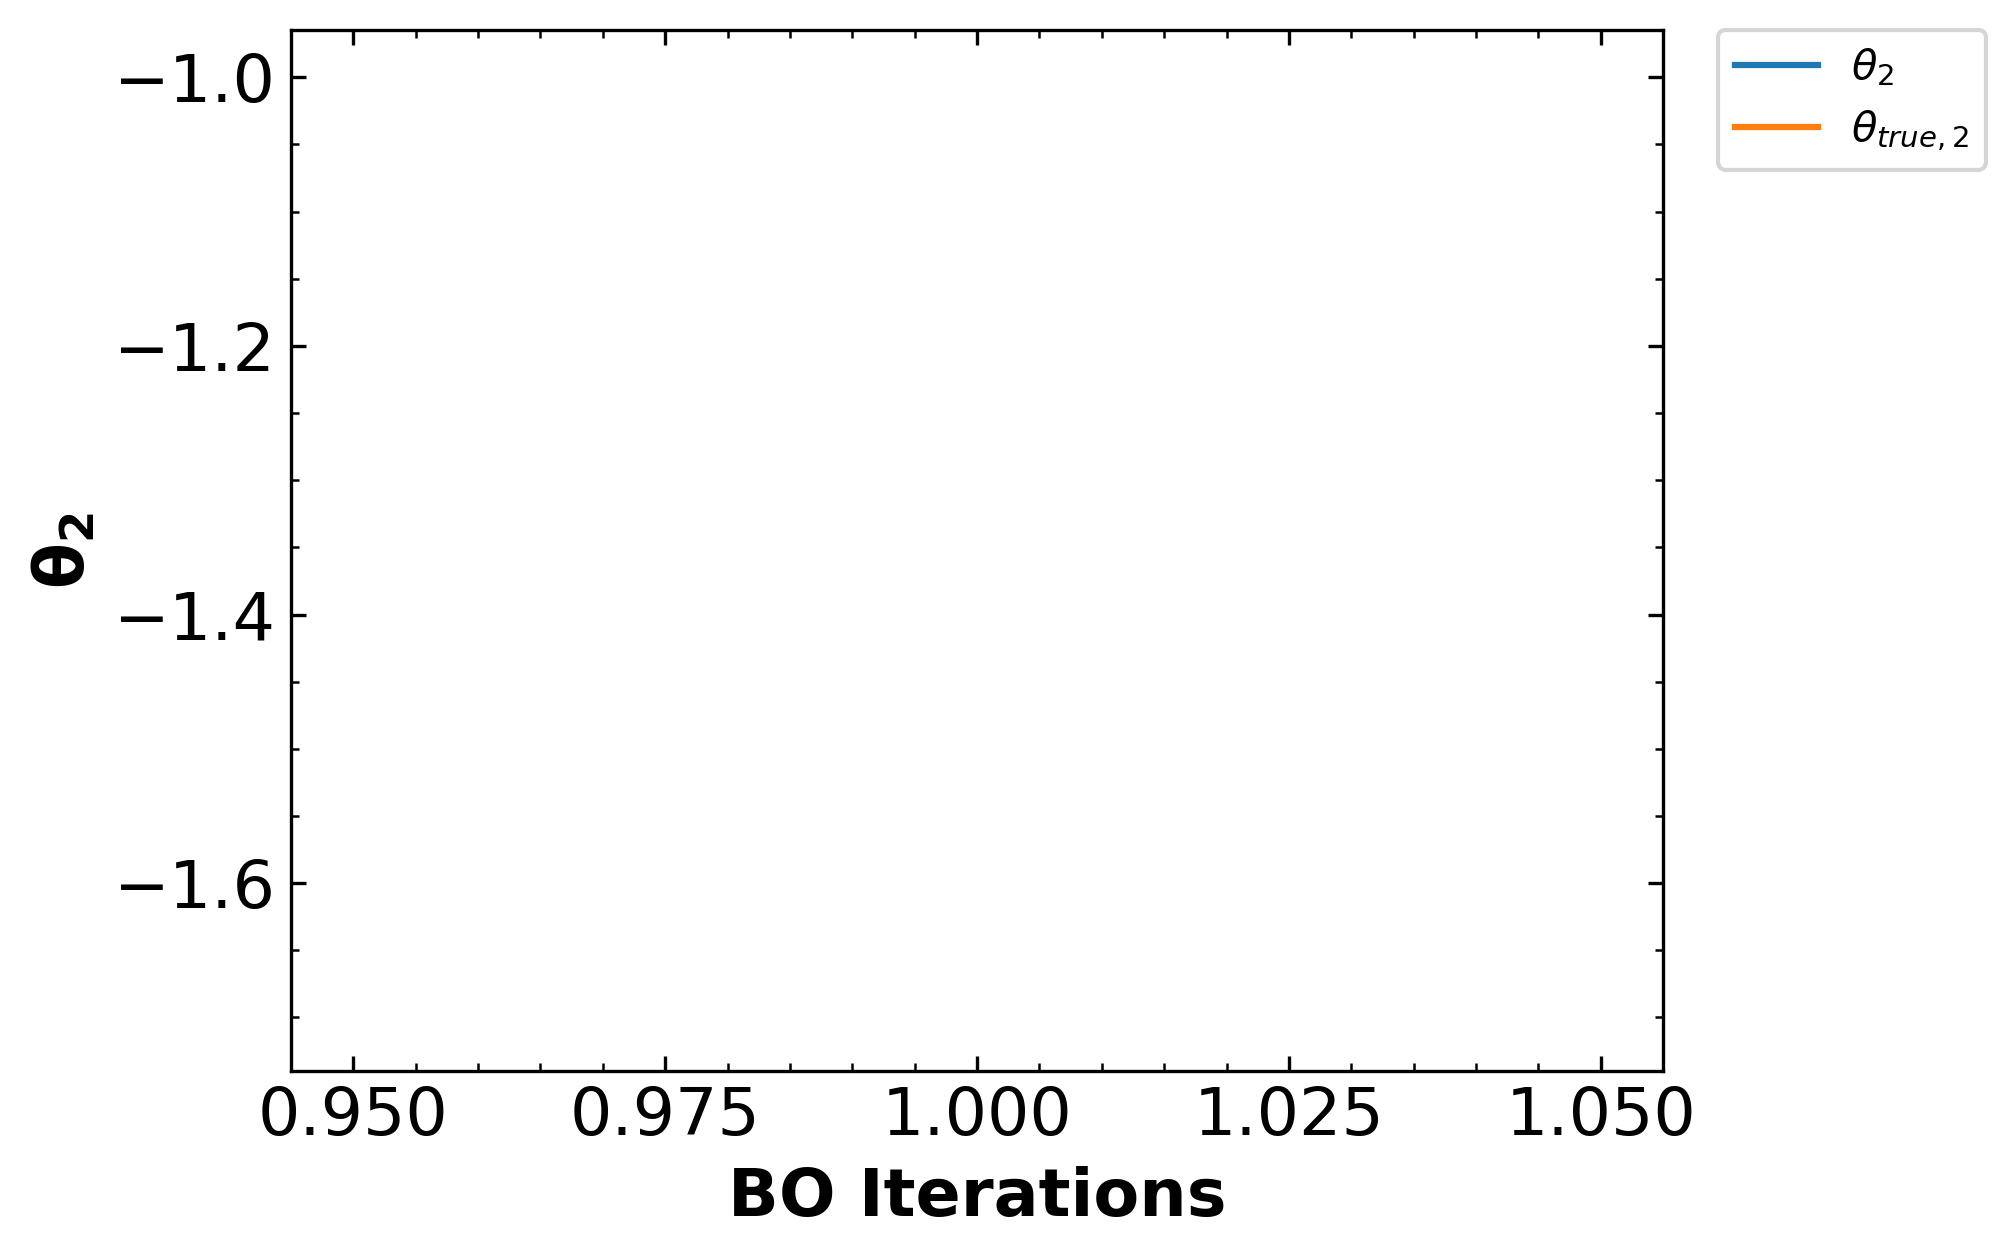

The GP predicts the lowest SSE of 1.673e+01 occurs at θ = [ 1.03694727 -1.70442801] during run 1 at BO iteration 1
At this point, the highest EI occurs at θ = [ 0.94736842 -1.78947368]




In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime

from bo_functions import bo_iter_w_runs
from bo_functions import find_train_doc_path
from bo_functions import set_ep

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#----------------------------------------------

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 1
runs = 1
train_iter = 300
noise_std = 0.1
shuffle_seed = 9
sep_fact = np.linspace(1,1,1)
set_lengthscale = None

obj = np.array(["obj"])
# obj = np.array(["obj","LN_obj"])
# emulator = False
emulator = np.array([False])
sparse_grid = np.array([False])
# sparse_grid = np.array([False,True])
verbose = False
save_fig = False
# save_fig = True

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays  

print("Runs:", runs)
print("BO Iterations:",BO_iters)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%")
for emul in emulator: 
    sys.stdout.flush()
    obj_use = obj
    print("-------------------")
    print("Emulator?:", emul)
    if emul == True:
        t = 100
        sparse_grid_use = sparse_grid
    else:
        t = 20
        sparse_grid_use = np.array([sparse_grid[0]]) #Sparse Grid will always be False for 2-Input
        
    for sparse in sparse_grid_use:
#         #Can set ep to 1 for sparse grid if wanted
        if sparse == True:
            obj_use =  np.array(["obj"])
        else:
            obj_use =  obj
#             ep_use = torch.tensor([1]) 
#         else:
#             ep_use = explore_bias
        print("______________________________")
        print("Sparse Grid?:", sparse)  

        for obj_func in obj_use:
            all_data_doc = find_train_doc_path(emul, obj_func, t)
            all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 
            print("Objective Function:", obj_func)
            print("-  -  -  -  -  -  -  -  -  -  -")
            for i in range(len(sep_fact)):
                explore_bias = set_ep(emul, obj_func, sparse)
                ep = torch.tensor([float(explore_bias)])
                print("Separation Factor Train/Test:", str(np.round(sep_fact[i],3)))
                print("Lengthscale Set To:", set_lengthscale)
                print("Explore Bias Multiplier:", str(np.round(float(ep),3)))
                results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,ep, Xexp, Yexp,
                                             noise_std, obj_func, runs, sparse, emul, set_lengthscale, verbose, 
                                             save_fig, shuffle_seed, DateTime, sep_fact = sep_fact[i])
                print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
                          "during run", results[1], "at BO iteration", results[0])
                print("At this point, the highest EI occurs at \u03B8 =", results[4][0])
                print("\n")